# Playlist Generation

### Goal: 

- Step 1: Top tracks: From a seed song find all top tracks from all related artists
- Step 2: Similar songs: From a seed song find all songs from related artists, and filter by similar songs based on Spotify API audio features 
- Step 3: Simple sampling to find the best playlist
- Step 4: Simulated Annealing to find the best playlist
- Step 5: Comparison and validation of methods

# Generate lists of candidate songs that fit into four buckets

**4 buckets of songs**

1. Top tracks from related artists
2. Tracks from related artists
3. Tracks from related artists identified as similar songs (using manhattan distance + Spotify API features)
3. Tracks from our database identified as similar (using raw audio  + vantage point method)

### Import Libraries and create spotify credentials manager

In [1]:
#!pip install pyemd

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
#importing module spotipy to make api calls to spotify
import spotipy
# module to extract song from url
import urllib
# OAuth Credenials
from spotipy.oauth2 import SpotifyClientCredentials
from multiprocessing import Process, Queue
import pandas as pd 
import numpy as np
from sklearn import datasets, linear_model
#from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
import math
client_credentials_manager = SpotifyClientCredentials(client_id='4a1a457d14c0445a96e7021a5523905b', client_secret='45b186d601544fdcbb4fe07c7b23cce5')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
#importing module spotipy to make api calls to spotify
# module to extract song from url

# OAuth Credenials

from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from scipy.optimize import linprog
from pyemd import emd


In [29]:
new_df = pd.read_pickle("Clustering_pickle")
new_df.head()

,id,means,var,weights,y
0,5bF6crgJa5Q58IWgbdUbuO,"[[0.040409079571, 0.00646461184292, 2.39260140...","[[[1e-06, 1.33009536784e-33, 4.80712114119e-31...","[0.0333333333333, 0.0333333333333, 0.1, 0.1333...","[4, 1, 14, 14, 15, 13, 0, 10, 8, 2, 8, 4, 9, 5..."
1,5BFMUpscSbYVT2V9j5d275,"[[0.0558062541101, 0.0855883695295, 3.17109792...","[[[1e-06, 2.42667172993e-32, 8.87468518374e-31...","[0.0333333333333, 0.0666666666667, 0.033333333...","[1, 13, 12, 3, 15, 3, 8, 6, 12, 3, 6, 8, 6, 2,..."
2,5bFxSkRAr1kiESBIkArOiP,"[[0.0659833556316, 0.0978295054857, 3.25550432...","[[[8.55154098213e-05, -5.1972411361e-06, 6.605...","[0.166666666667, 0.0666666666667, 0.0333333333...","[12, 0, 0, 4, 3, 1, 7, 10, 14, 15, 9, 13, 2, 1..."
3,5bG5GUKVJztKR5nff1CwUp,"[[0.0294677883852, 0.0119775199815, 3.10904883...","[[[0.000136061091959, 3.51617999053e-05, 0.000...","[0.0666666666667, 0.0666666666667, 0.1, 0.0333...","[5, 13, 8, 15, 14, 2, 2, 10, 5, 1, 11, 11, 2, ..."
4,5BgC5vVuhfWHHawbcXRr7h,"[[0.0558289303612, 0.0524681203747, 3.24543361...","[[[1e-06, 1.47333640746e-32, 8.87468518374e-31...","[0.0333333333333, 0.2, 0.0333333333333, 0.0666...","[1, 1, 1, 1, 14, 15, 7, 15, 9, 4, 15, 0, 13, 5..."


In [30]:
mean_features_data = pd.read_csv('mean_features_data_with_id.csv').drop('Unnamed: 0', axis = 1)
mean_features_data.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,id
0,0.034331,0.027217,3.032119,0.100629,0.144193,0.094455,0.001504,0.038918,-20.449001,2.142264,...,0.000543,0.000259,0.000311,0.000444,0.000484,0.000725,0.000527,0.000368,0.000397,5bF6crgJa5Q58IWgbdUbuO
1,0.080249,0.063066,3.154067,0.179655,0.186982,0.676640,0.000210,0.105036,-17.555998,0.956587,...,0.000924,0.001856,0.000515,0.001718,0.001182,0.001021,0.001049,0.001231,0.000844,5BFMUpscSbYVT2V9j5d275
2,0.055129,0.094738,3.248476,0.168248,0.191879,0.350973,0.000328,0.043137,-17.683683,2.139082,...,0.001474,0.000988,0.001536,0.002911,0.000818,0.001129,0.000644,0.001056,0.001052,5bFxSkRAr1kiESBIkArOiP
3,0.035782,0.026939,3.152187,0.107575,0.149364,0.172294,0.001276,0.039265,-20.296906,2.452144,...,0.001199,0.002105,0.000745,0.002304,0.003827,0.003836,0.004233,0.003712,0.003389,5bG5GUKVJztKR5nff1CwUp
4,0.057428,0.062834,3.061450,0.131380,0.152100,0.427569,0.000472,0.075542,-17.584650,1.820407,...,0.000912,0.001501,0.002080,0.001376,0.002700,0.004059,0.001817,0.001280,0.002206,5BgC5vVuhfWHHawbcXRr7h


In [31]:
from sklearn.cluster import KMeans
cols = np.array(range(0,34))
kmeans = KMeans(n_clusters=300, random_state=0).fit(mean_features_data[cols])

In [32]:
def distance_between_clusters(mu_1, sig_1, mu_2, sig_2):
    
    means_diff_1 = mu_1- mu_2
    means_diff_2 = mu_2- mu_1
    sig_1_inv = np.linalg.inv(sig_1)
    sig_2_inv = np.linalg.inv(sig_2)
    dist = np.trace(np.dot(np.linalg.inv(sig_1) , sig_2)) + np.trace(np.dot(np.linalg.inv(sig_2) , sig_1)) + np.dot(np.dot(means_diff_1.T,sig_1_inv),means_diff_1) +np.dot(np.dot(means_diff_2.T,sig_2_inv),means_diff_2) 
    return dist


In [33]:
#!pip install pydub

In [37]:
# code to calculate emd between two songs
def calc_emd(signature_1, signature_2):
    p_list = []
    for i in signature_1['weights']:
        p_list.append(i)
    
    q_list = []
    for i in signature_2['weights']:
        q_list.append(i)
    
    clus_1 = signature_1['means'].shape[0]
    clus_2 = signature_2['means'].shape[0]
    dist = np.zeros((clus_1*clus_2))
    p_list = np.array(p_list)
    q_list = np.array(q_list)
    col = 0
    for i in range(0, clus_1):
        for j in range(0, clus_2):
            dist[col]=distance_between_clusters(signature_1['means'][i],signature_1['var'][i], signature_2['means'][j], signature_2['var'][j])
            col+=1
    #clus_1 = clus_2 = 4
    A_ub = np.zeros((clus_1+clus_2, clus_1*clus_2))
    j = 0
    for i in range(0, clus_1):
        A_ub[i][j:j+clus_2] = 1
        j+=clus_2

    #print(A_ub)
    k = 0
    for i in range(clus_1, clus_1+clus_2):
        
        for j in range(k, clus_1*clus_2, clus_2):
            
            A_ub[i][j] = 1
        k = k+1
    #print(A_ub)
    b_ub = np.zeros(clus_1 + clus_2)
    b_ub[0:clus_1] = p_list
    b_ub[clus_1:] = q_list
    A_eq = np.ones((1,clus_1*clus_2))
    b_eq = min(np.sum(p_list), np.sum(q_list))

    res = linprog(c = dist,A_ub = A_ub,b_ub= b_ub,A_eq = A_eq, b_eq = b_eq,options={"disp": True})
    
    f_star = np.array(res['x'])

    num = np.dot(f_star, dist)
    denom = np.sum(f_star)
    #print(f_star, num, denom)
    return(num/denom)

import os, glob, eyed3, ntpath, shutil, numpy
import scipy.io.wavfile as wavfile
from pydub import AudioSegment
def readAF(path):
    '''
    This function returns a numpy array that stores the audio samples of a specified WAV of AIFF file
    '''
    extension = os.path.splitext(path)[1]
    try:
        #if extension.lower() == '.wav':
            #[Fs, x] = wavfile.read(path)
        if extension.lower() == '.aif' or extension.lower() == '.aiff':
            s = aifc.open(path, 'r')
            nframes = s.getnframes()
            strsig = s.readframes(nframes)
            x = numpy.fromstring(strsig, numpy.short).byteswap()
            Fs = s.getframerate()
        elif extension.lower() == '.mp3' or extension.lower() == '.wav':
            audiofile = AudioSegment.from_file(path)
            data = numpy.fromstring(audiofile._data, numpy.int16)
            Fs = audiofile.frame_rate
            x = []
            for chn in xrange(audiofile.channels):
                x.append(data[chn::audiofile.channels])
            x = numpy.array(x).T
        else:
            print("Error in readAudioFile(): Unknown file type!")
            return (-1,-1)
    except IOError: 
        print("Error: file not found or other I/O error.")
        return (-1,-1)
    return (Fs, x)


In [38]:
#!pip install libav-tools

In [42]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction
import matplotlib.pyplot as plt
import numpy as np
import glob, os
# os.chdir("/Users/sonumehta/Desktop/Sem2/Capstone/PyAudio_tools/pyAudioAnalysis/raw_audio")

# features = []

# for file in glob.glob("*.wav"):
#     [Fs, x] = audioBasicIO.readAudioFile("track0A71OLE9BN4ImZ3XTCOHP7.wav");
#     F = audioFeatureExtraction.stFeatureExtraction(x[:,1], Fs, 1* Fs, 1*Fs);
    
#     features.append(np.mean(F, axis = 1))
#     break
# print(np.array(features).shape)
    
# features is array with 12 song having 24 features each.
from scipy.io import wavfile

def return_candidate_songs(seed_song): # seed_song is the track_id
    
    # extract raw audio #
    track_spotify = sp.tracks([seed_song])['tracks'][0]
    
    urllib.urlretrieve(track_spotify['preview_url'], "track"+track_spotify['id']+".wav")
    # extract acoustic features
    print("track"+track_spotify['id']+".wav")
    #[Fs, x] = readAF("track"+track_spotify['id']+".wav")
    [Fs, x] = wavfile.read("track"+'0au8IZN1gZgvpMkpzKxwpo'+".wav")
    F = audioFeatureExtraction.stFeatureExtraction(x[:,1], Fs, 1* Fs, 1*Fs);

#     # predict the nearest vantage point
    vp_nearest = kmeans.predict(np.mean(F, axis = 1).reshape(1,-1))
    print(vp_nearest)
    #All songs in that cluster
    nearest_song_index = np.where(kmeans.labels_ == vp_nearest)

    return(track_id.iloc[nearest_song_index]['trackid'].values)

#[Fs, x] = audioBasicIO.readAudioFile("track5bG5GUKVJztKR5nff1CwUp.wav");
print(return_candidate_songs('0au8IZN1gZgvpMkpzKxwpo'))


track0au8IZN1gZgvpMkpzKxwpo.wav


ValueError: File format 'ID3\x04'... not understood.

In [10]:
#!pip install pyAudioAnalysis
import urllib2
print(sp.tracks([seed])['tracks'][0]['preview_url'])
f=file('test.mp3', 'w')
seed = '5bG5GUKVJztKR5nff1CwUp'
url=urllib2.urlopen(sp.tracks([seed])['tracks'][0]['preview_url'])
url
f.write(url.read(1024))

NameError: name 'seed' is not defined

### Read in csv that has the track ids from all Spotify playlists

In [15]:
track_info = pd.read_csv("kmeans_output.csv")
track_ids = list(track_info['id'])
print(len(track_ids), "example track ids", "\n")
print(track_ids[:15])
track_result = sp.tracks(["1tpShM80HMT9vKjRiA3EzW"])

(14887, 'example track ids', '\n')
['1tPGSiwtvmMVAqmniJ7oHp', '1tpShM80HMT9vKjRiA3EzW', '1TPUbLdzpfgF7wrPEXIAAB', '1tQGRq2WOBXjL3JWdWMONg', '1TqmZVIyeD4aN4Wa0wbnfy', '1TquBahz02HCaxj8jy5tTo', '1Tr4K5MU5XYE44umXGDndd', '1tRlCCMVLSVQrrN9PPgtf0', '1TScJLsDWzDVBFpCU5vJDo', '1TSjS0q24cPW2S4pYj2wEK', '1Tt4sE4pXi57mTD1GCzsqm', '1TtdHZ4KvN56LCt9evBUaL', '1TTiZwoorWMR4KmaI0irjU', '1TtJJ7YP6JCQ3aH8PQpreD', '1TTOAw90zzNWKnUgzzcvZW']


### Input a seed track

In [16]:
seed_id = "7qiZfU4dY1lWllzX7mPBI3"
track_info = sp.tracks([seed_id])
name = track_info['tracks'][0]['name']
seed_preview_url = track_info['tracks'][0]['preview_url']
print("ID: ", seed_id, "\n \n Artist name: ",track_info['tracks'][0]['artists'][0]['name'], "\n Track name: ",name)

('ID: ', '7qiZfU4dY1lWllzX7mPBI3', '\n \n Artist name: ', u'Ed Sheeran', '\n Track name: ', u'Shape of You')


### Get the track's artists

In [17]:
artist_names = []
artist_ids = []
for each in track_info['tracks'][0]['artists']:
    artist_names.append(each['name'])
    artist_ids.append(each['id'])
print(artist_names)
print(artist_ids,"\n")
print(len(artist_names), "artist(s)")

[u'Ed Sheeran']
([u'6eUKZXaKkcviH0Ku9w2n3V'], '\n')
(1, 'artist(s)')


### Get related artists

In [18]:
all_related_artists_names = []
all_related_artists_ids = []

for each in artist_ids:
    related = sp.artist_related_artists(each)
    for related_artist in related['artists']:
        all_related_artists_names.append(related_artist['name'])
        all_related_artists_ids.append(related_artist['id'])
all_related_artists_ids = np.array(all_related_artists_ids)
all_related_artists_ids_unique = np.unique(all_related_artists_ids)
print(len(all_related_artists_ids_unique), "related artists")

(20, 'related artists')


### Bucket #1: Top tracks from the related artists

In [19]:
top_tracks_related_artists = []
for each in all_related_artists_ids_unique:    
    top_tracks_one_artist = sp.artist_top_tracks(each)

    for each in top_tracks_one_artist['tracks']:
        song = each['id']
        top_tracks_related_artists.append(song)
        
print(len(top_tracks_related_artists),"top tracks from related artists")

(191, 'top tracks from related artists')


### Bucket #2: Songs from related artists that are not in top tracks but are similar

In [20]:
print("Finding albums from related artists...")
all_related_albums = []
for each in all_related_artists_ids_unique:    
    albums = sp.artist_albums(each, album_type=None, country=None, limit=50, offset=0)
    for each in albums['items']:
        album_id = each['id']
        all_related_albums.append(album_id)
sp.album_tracks(all_related_albums[1], limit=50, offset=0)
print("Finding songs from those albums...")

all_related_songs = []
all_related_preview_urls = []
for index, each_album in enumerate(all_related_albums):
    album_tracks = sp.album_tracks(each_album, limit=50, offset=0)
    if index%50==0: print(index)
    for each in album_tracks['items']:
        all_related_songs.append(each['id'])
        all_related_preview_urls.append(each['preview_url'])
all_related_songs = np.array(all_related_songs)
all_related_songs = list(np.unique(all_related_songs))
combined = [seed_id]
combined.extend(all_related_songs)
all_related_songs = combined
print(len(all_related_songs), " songs from related artists")

Finding albums from related artists...
Finding songs from those albums...
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
(9784, ' songs from related artists')


### Test to make sure the songs sound like they're from related artists

In [21]:
from IPython.core.display import HTML

In [22]:
link = '<a href=' + str(seed_preview_url) + '>preview input song</a>'
#display(HTML(link))
HTML(link)


In [23]:
link = '<a href=' + str(all_related_preview_urls[10]) + '>preview related song</a>'
HTML(link)


### Function to get Spotify API features given a list of track ids

In [24]:
def get_spotify_features(track_ids,numLoops=None):
    track_ids_all= []
    popularity = []
    preview_urls_all =[]
    artists_all = []
    names_all = []
    track_numbers_all = []
    num_markets = []
    
    # set parameters
    offset=0
    limit=50
    if numLoops==None: 
        numLoops=int(math.floor(len(track_ids)/50)+1)
    aud_features = np.empty((limit*numLoops, 13))
    for loopIndex in range(numLoops):
        start = offset + limit*loopIndex # start 
        tracks = track_ids[start:start+limit]
        try:
            tracks_list = sp.tracks(tracks)
            features = sp.audio_features(tracks=tracks)
        except:
            print("Couldn't get data", index)
            continue
        for index, track in enumerate(tracks_list['tracks']):
            
            try:
                if (start+index)%1000==0: 
                    print(index+1+start)
                preview_urls_all.append(track['preview_url'])
                track_ids_all.append(track['id'])
                popularity.append(track['popularity'])
                names_all.append(track['name'])
                artists_all.append(track['artists'][0]['name'])
                track_numbers_all.append(track['track_number'])
                num_markets.append(track['available_markets'])
                songData = features[index]
                aud_features[index+start][0] = songData['acousticness']
                aud_features[index+start][1] = songData['danceability']
                aud_features[index+start][2] = songData['energy']
                aud_features[index+start][3] = songData['instrumentalness']
                aud_features[index+start][4] = songData['key']
                aud_features[index+start][5] = songData['liveness']
                aud_features[index+start][6] = songData['loudness']
                aud_features[index+start][7] = songData['mode']
                aud_features[index+start][8] = songData['tempo']
                aud_features[index+start][9] = songData['time_signature']
                aud_features[index+start][10] = songData['valence']
                aud_features[index+start][11] = songData['duration_ms']
                aud_features[index+start][12] = songData['speechiness']
                 
            except:
                print("Some fields not available", index)

    aud_features = aud_features[:len(names_all),]
    track_data = pd.DataFrame({
    'preview_url': preview_urls_all,
    'id': track_ids_all,
    'popularity': popularity,
    'artists': artists_all,
    'names': names_all,
    'acousticness': aud_features[:,0],
    'danceability': aud_features[:,1],
    'energy': aud_features[:,2],
    'instrumentalness': aud_features[:,3],
    'key': aud_features[:,4],
    'liveness': aud_features[:,5],
    'loudness': aud_features[:,6],
    'mode': aud_features[:,7],
    'tempo': aud_features[:,8],
    'time_signature': aud_features[:,9],
    'valence': aud_features[:,10],
    'duration': aud_features[:,11],
    'speechiness': aud_features[:,12],
    'available_markets': num_markets
    
   
    })
    #q.put(track_data)
    print(len(num_markets), len(popularity), aud_features.shape)
    #name = multiprocessing.current_process().name
    print('Exiting')
    return track_data


### Get all Spotify features for Bucket 1

In [25]:
print(len(top_tracks_related_artists))
top_tracks_df = get_spotify_features(track_ids=top_tracks_related_artists) 

191
1
(191, 191, (191, 13))
Exiting


In [26]:
top_tracks_df.head()

,acousticness,artists,available_markets,danceability,duration,energy,id,instrumentalness,key,liveness,loudness,mode,names,popularity,preview_url,speechiness,tempo,time_signature,valence
0,0.583,Ellie Goulding,"[CA, MX, US]",0.430,240867.0,0.530,3odrUVQ9tvRpkC9II2oWzx,0.000000,1.0,0.102,-7.941,1.0,"Still Falling For You - From ""Bridget Jones's ...",70,https://p.scdn.co/mp3-preview/9afcd95ec52726e1...,0.0447,96.140,4.0,0.166
1,0.197,Kygo,"[AD, AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, C...",0.633,193511.0,0.592,2Gl0FzuLxflY6nPifJp5Dr,0.000000,0.0,0.099,-7.245,0.0,First Time,74,https://p.scdn.co/mp3-preview/f5e35495b56260a0...,0.1120,90.066,4.0,0.643
2,0.240,Ellie Goulding,"[CA, MX, US]",0.254,252534.0,0.617,2l8w0zZVn4AZNuzrht7MRT,0.000000,5.0,0.125,-6.612,0.0,"Love Me Like You Do - From ""Fifty Shades Of Grey""",73,https://p.scdn.co/mp3-preview/a4e18eb3de6b8e6b...,0.0537,189.425,4.0,0.271
3,0.296,Ellie Goulding,"[CA, MX, US]",0.516,231212.0,0.772,0xMd5bcWTbyXS7wPrBtZA6,0.000000,10.0,0.101,-5.031,0.0,Burn,71,https://p.scdn.co/mp3-preview/b0b06f9ee468d539...,0.0476,87.038,4.0,0.319
4,0.227,Ellie Goulding,"[CA, MX, US]",0.510,154435.0,0.308,0ZPfDxZn5O0L84wvPSN2iG,0.000313,0.0,0.120,-9.168,1.0,How Long Will I Love You - Bonus Track,67,https://p.scdn.co/mp3-preview/e206717cf7253882...,0.0321,126.349,5.0,0.146


### Get Spotify API Features for Bucket 2

In [27]:
features_df = get_spotify_features(track_ids=all_related_songs)

1
1001
2001
3001
4001
5001
6001
7001
8001
9001
(9784, 9784, (9784, 13))
Exiting


In [52]:
features_df.head()

,acousticness,artists,available_markets,danceability,duration,energy,id,instrumentalness,key,liveness,loudness,mode,names,popularity,preview_url,speechiness,tempo,time_signature,valence
0,0.58100,Ed Sheeran,"[AD, AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, C...",0.825,233713.0,0.652,7qiZfU4dY1lWllzX7mPBI3,0.00000,1.0,0.0931,-3.183,0.0,Shape of You,99,https://p.scdn.co/mp3-preview/84462d8e1e4d0f9e...,0.0802,95.977,4.0,0.933
1,0.13100,ZAYN,"[AD, AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, C...",0.748,188491.0,0.627,000xQL6tZNLJzIrtIgxqSl,0.00000,7.0,0.0852,-6.029,1.0,Still Got Time,91,https://p.scdn.co/mp3-preview/2385471a5d35709a...,0.0644,120.963,4.0,0.513
2,0.09170,Sia,[PL],0.633,217040.0,0.711,005Ua0AZQDAtOpavz5kdpW,0.00178,10.0,0.4770,-7.508,0.0,Move Your Body - Alan Walker Remix,16,https://p.scdn.co/mp3-preview/2e6451d064b9d6f7...,0.1090,128.012,4.0,0.375
3,0.00883,Sidonie,[ES],0.702,268947.0,0.824,006dQ6824YZgSvIvBRhcJT,0.00000,6.0,0.0766,-4.724,1.0,Carreteras Infinitas,22,https://p.scdn.co/mp3-preview/5527a471067cde16...,0.0343,104.004,4.0,0.785
4,0.40800,Herbie Hancock,[],0.488,325120.0,0.491,007Dbxrxk5XF2axpc9ENdG,0.00000,0.0,0.0941,-13.094,0.0,Cantaloupe Island,0,None,0.0288,116.136,4.0,0.458


## Find most similar songs acoustically

### Calculate the distance between the input song and related songs

In [53]:
from scipy.spatial.distance import cityblock
distance_features = features_df[['acousticness', 'danceability', 
                                 'duration', 'energy', 'instrumentalness', 'liveness', 
                                 'loudness', 'speechiness', 'tempo', 'valence']]
distance_features.head()

,acousticness,danceability,duration,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.58100,0.825,233713.0,0.652,0.00000,0.0931,-3.183,0.0802,95.977,0.933
1,0.13100,0.748,188491.0,0.627,0.00000,0.0852,-6.029,0.0644,120.963,0.513
2,0.09170,0.633,217040.0,0.711,0.00178,0.4770,-7.508,0.1090,128.012,0.375
3,0.00883,0.702,268947.0,0.824,0.00000,0.0766,-4.724,0.0343,104.004,0.785
4,0.40800,0.488,325120.0,0.491,0.00000,0.0941,-13.094,0.0288,116.136,0.458


In [54]:
seed_features = distance_features.ix[0,]
related_features = distance_features.ix[1:,]
print(len(related_features))
sample_size = len(related_features)
distance_vector = np.empty((sample_size))
for index,row in related_features.iterrows():
    if index>sample_size-1: break
    #print(row)
    distance_vector[index]=cityblock(seed_features, row)
print(distance_vector.shape)
distance_vector[10015]

10433
(10433,)


37486.232705379996

### Sort the distance output and find the 500 most acoustically similar songs

In [65]:
from IPython.display import HTML, display
min_indices = distance_vector.argsort()[0:500:]
top_similarity_index = min_indices[2]
top_similarity_index
related_all_features_with_seed = features_df.ix[:]
seed_all_features = features_df.ix[0,]
link = '<a href=' + str(seed_all_features['preview_url']) + '>preview seed song</a>'
display(HTML(link))
for each in range(10):
    print(related_all_features_with_seed['artists'][min_indices[each]], related_all_features_with_seed['id'][min_indices[each]])
    link = '<a href=' + str(related_all_features_with_seed['preview_url'][min_indices[each]]) + '>preview related song #'+str(each)+ '</a>'
    display(HTML(link))

Ed Sheeran 7qiZfU4dY1lWllzX7mPBI3


Crowded House 6lLPLfz3R9LMxlLu5r1ms9


MØ 1FDRsQSUu2l88pCde68XxZ


Calvin Harris 2nPYML5WnGJBiOrBnMsjfp


Ellie Goulding 5EurZLrwTEL7eUVtr0zHiT


Ellie Goulding 6n7wUelYPaKsuL2HmrmlBY


Christine and the Queens 0cQXynqlLIPaY2GKV3y4SD


Solano 0TGtD6fbpp2MIzwFdtEyXx


All Saints 5dKpYLYmuN6t12ucMLvBJM


Daniel Powter 5SraAzB6oA1mwWj9vvNZG6


In [49]:
#features_df.to_csv('related_songs.csv', encoding='utf-8')

### Bucket 1: Top tracks from related artists

In [66]:
print(top_tracks_df.shape)
nona = top_tracks_df.dropna()
print(nona.shape)
bucket1 = nona['id'].values
bucket1[:5]

(200, 19)
(198, 19)


array([u'3odrUVQ9tvRpkC9II2oWzx', u'2l8w0zZVn4AZNuzrht7MRT',
       u'0xMd5bcWTbyXS7wPrBtZA6', u'0ZPfDxZn5O0L84wvPSN2iG',
       u'4nS1sut0R2mgmFitKIShVe'], dtype=object)

### Bucket 2: Any tracks from related artists

In [67]:
nona = features_df.dropna()
print(nona.shape)
all_related_songs = nona['id'].values
print(all_related_songs.shape)
bucket2 = all_related_songs
bucket2[:5]

(6600, 19)
(6600,)


array([u'7qiZfU4dY1lWllzX7mPBI3', u'000xQL6tZNLJzIrtIgxqSl',
       u'005Ua0AZQDAtOpavz5kdpW', u'006dQ6824YZgSvIvBRhcJT',
       u'00Ctb7lezRAv5r2xuvWbrf'], dtype=object)

### Bucket 3: Tracks from related artists identified as similar songs (using manhattan distance + Spotify API features)

In [68]:
bucket3 = related_all_features_with_seed['id'][min_indices].values
bucket3[:5]

array([u'7qiZfU4dY1lWllzX7mPBI3', u'6lLPLfz3R9LMxlLu5r1ms9',
       u'1FDRsQSUu2l88pCde68XxZ', u'2nPYML5WnGJBiOrBnMsjfp',
       u'5EurZLrwTEL7eUVtr0zHiT'], dtype=object)

### Bucket 4: Tracks from our database identified as similar (using raw audio  + vantage point method)

# Optimization

### Train Random Forest Model

In [69]:
## Popularity Prediction for New Playlist

#libraries

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.cross_validation import train_test_split
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import sys
from sklearn.metrics import mean_squared_error
from math import sqrt

# Step 1 - train the random forest

api_data = pd.read_csv('playlist_data_with_sequencing_4.8.17.csv')
api_data = api_data.dropna()
del api_data['Unnamed: 0']
del api_data['names']
del api_data['playlist_id']
api_data.head()

a = pd.qcut(api_data["followers"], 5,labels=range(1,6))
api_data['followers'] = np.array(a)

y = api_data['followers']
X = api_data.drop(['followers'],axis=1)
X = X.drop(['featured'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


rfc = RFC(n_estimators = 100, max_depth = 29)
rfc.fit(X_train, y_train)

client_credentials_manager = SpotifyClientCredentials(client_id='df846cfd28e745178054587b3484f91c',client_secret='e3d39fc92a954e028ff1490288f3fe5c')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


/Users/lw20302/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Function to generate predicted class probabilities for playlist popularity from a list of input track ids

In [70]:
def getTrack(track_id):
    #print(track_id)
    try:
        listing = features_df[features_df['id']==track_id]
        popularity = listing['popularity'].values[0]
    except IndexError:
        listing = top_tracks_df[top_tracks_df['id']==track_id]
    popularity = listing['popularity'].values[0]
    num_markets = listing['available_markets'].values[0]
    return {"popularity": popularity,
           'available_markets': num_markets}

def getAudioFeatures(list_of_ids):
    try:
        listing = features_df[features_df['id'].isin(list_of_ids)]
        acousticness = listing['acousticness'].values[0]
    except:
        listing = top_tracks_df[top_tracks_df['id'].isin(list_of_ids)]
    return listing[['acousticness', 'danceability', 
                                 'energy', 'instrumentalness', 'key','liveness', 
                                 'loudness', 'mode','tempo','time_signature','valence','duration']].values
def chunks(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0
    
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
        
    return out

def gen_row(list_of_tracks):
            
    parts = chunks(list_of_tracks,4)
                    
    p1 = parts[0]
    p2 = parts[1]
    p3 = parts[2]
    p4 = parts[3]
    
    t_popularities = []
    t_num_markets = []
                
    for track in list_of_tracks:
        listing = getTrack(track)
        t_popularities.append(listing['popularity'])
        t_num_markets.append(len(listing['available_markets']))
                                        
    t_pop = np.mean(t_popularities)
    t_av_num_markets = np.mean(t_num_markets)

    #t_features = sp.audio_features(tracks = list_of_tracks)
    feat_len = len(list_of_tracks)
    #t_feature_matrix = np.empty((feat_len,12))
    t_feature_matrix = getAudioFeatures(list_of_tracks)
#     for ix, song in enumerate(t_features):
  
#         t_feature_matrix[ix][0] = song['acousticness']
#         t_feature_matrix[ix][1] = song['danceability']
#         t_feature_matrix[ix][2] = song['energy']
#         t_feature_matrix[ix][3] = song['instrumentalness']
#         t_feature_matrix[ix][4] = song['key']
#         t_feature_matrix[ix][5] = song['liveness']
#         t_feature_matrix[ix][6] = song['loudness']
#         t_feature_matrix[ix][7] = song['mode']
#         t_feature_matrix[ix][8] = song['tempo']
#         t_feature_matrix[ix][9] = song['time_signature']
#         t_feature_matrix[ix][10] = song['valence']
#         t_feature_matrix[ix][11] = song['duration_ms']
                            
    t_feature_median = np.percentile(t_feature_matrix,50,axis=0)
                    # Part 1
                    
    p1_popularities = []
    p1_num_markets = []
                    
    for track in p1:
        listing = getTrack(track)
        p1_popularities.append(listing['popularity'])
        p1_num_markets.append(len(listing['available_markets']))
    
    p1_pop = np.mean(p1_popularities)
    p1_av_num_markets = np.mean(p1_num_markets)
    
    #p1_features = sp.audio_features(tracks = p1)
    p1_len = len(p1)
    #p1_feature_matrix = np.empty((p1_len,12))
    p1_feature_matrix = getAudioFeatures(p1)
                    
#     for ix, song in enumerate(p1_features):
#         p1_feature_matrix[ix][0] = song['acousticness']
#         p1_feature_matrix[ix][1] = song['danceability']
#         p1_feature_matrix[ix][2] = song['energy']
#         p1_feature_matrix[ix][3] = song['instrumentalness']
#         p1_feature_matrix[ix][4] = song['key']
#         p1_feature_matrix[ix][5] = song['liveness']
#         p1_feature_matrix[ix][6] = song['loudness']
#         p1_feature_matrix[ix][7] = song['mode']
#         p1_feature_matrix[ix][8] = song['tempo']
#         p1_feature_matrix[ix][9] = song['time_signature']
#         p1_feature_matrix[ix][10] = song['valence']
#         p1_feature_matrix[ix][11] = song['duration_ms']
                        
    p1_feature_median = np.percentile(p1_feature_matrix,50,axis=0)
                    # Part 2
                    
    p2_popularities = []
    p2_num_markets = []
                    
    for track in p2:
        listing = getTrack(track)
        p2_popularities.append(listing['popularity'])
        p2_num_markets.append(len(listing['available_markets']))
    
    p2_pop = np.mean(p2_popularities)
    p2_av_num_markets = np.mean(p2_num_markets)
    
    #p2_features = sp.audio_features(tracks = p2)

    p2_len = len(p2)
    #p2_feature_matrix = np.empty((p2_len,12))
    p2_feature_matrix = getAudioFeatures(p2)
                 
#     for ix, song in enumerate(p2_features):
#         p2_feature_matrix[ix][0] = song['acousticness']
#         p2_feature_matrix[ix][1] = song['danceability']
#         p2_feature_matrix[ix][2] = song['energy']
#         p2_feature_matrix[ix][3] = song['instrumentalness']
#         p2_feature_matrix[ix][4] = song['key']
#         p2_feature_matrix[ix][5] = song['liveness']
#         p2_feature_matrix[ix][6] = song['loudness']
#         p2_feature_matrix[ix][7] = song['mode']
#         p2_feature_matrix[ix][8] = song['tempo']
#         p2_feature_matrix[ix][9] = song['time_signature']
#         p2_feature_matrix[ix][10] = song['valence']
#         p2_feature_matrix[ix][11] = song['duration_ms']
                        
    p2_feature_median = np.percentile(p2_feature_matrix,50,axis=0)
    
                        # Part 3
                    
    p3_popularities = []
    p3_num_markets = []
                  
    for track in p3:
        listing = getTrack(track)
        p3_popularities.append(listing['popularity'])
        p3_num_markets.append(len(listing['available_markets']))
    
    p3_pop = np.mean(p3_popularities)
    p3_av_num_markets = np.mean(p3_num_markets)
    
    #p3_features = sp.audio_features(tracks = p3)
    p3_len = len(p3)
    #p3_feature_matrix = np.empty((p3_len,12))
    p3_feature_matrix = getAudioFeatures(p3)
                
#     for ix, song in enumerate(p3_features):
#         p3_feature_matrix[ix][0] = song['acousticness']
#         p3_feature_matrix[ix][1] = song['danceability']
#         p3_feature_matrix[ix][2] = song['energy']
#         p3_feature_matrix[ix][3] = song['instrumentalness']
#         p3_feature_matrix[ix][4] = song['key']
#         p3_feature_matrix[ix][5] = song['liveness']
#         p3_feature_matrix[ix][6] = song['loudness']
#         p3_feature_matrix[ix][7] = song['mode']
#         p3_feature_matrix[ix][8] = song['tempo']
#         p3_feature_matrix[ix][9] = song['time_signature']
#         p3_feature_matrix[ix][10] = song['valence']
#         p3_feature_matrix[ix][11] = song['duration_ms']
                        
    p3_feature_median = np.percentile(p3_feature_matrix,50,axis=0)
    
                        # Part 4
                    
    p4_popularities = []
    p4_num_markets = []
                    
    for track in p4:
        listing = getTrack(track)
        p4_popularities.append(listing['popularity'])
        p4_num_markets.append(len(listing['available_markets']))
    
    p4_pop = np.mean(p4_popularities)
    p4_av_num_markets = np.mean(p4_num_markets)
    
    #p4_features = sp.audio_features(tracks = p4)
    p4_len = len(p4)
    #p4_feature_matrix = np.empty((p4_len,12))
    p4_feature_matrix = getAudioFeatures(p4)
             
#     for ix, song in enumerate(p4_features):
#         p4_feature_matrix[ix][0] = song['acousticness']
#         p4_feature_matrix[ix][1] = song['danceability']
#         p4_feature_matrix[ix][2] = song['energy']
#         p4_feature_matrix[ix][3] = song['instrumentalness']
#         p4_feature_matrix[ix][4] = song['key']
#         p4_feature_matrix[ix][5] = song['liveness']
#         p4_feature_matrix[ix][6] = song['loudness']
#         p4_feature_matrix[ix][7] = song['mode']
#         p4_feature_matrix[ix][8] = song['tempo']
#         p4_feature_matrix[ix][9] = song['time_signature']
#         p4_feature_matrix[ix][10] = song['valence']
#         p4_feature_matrix[ix][11] = song['duration_ms']
                        
    p4_feature_median = np.percentile(p4_feature_matrix,50,axis=0)
           
    playlist_data = pd.Series({
                    #'followers': followers,
                    #'names' : names,
                    #'playlist_id' : playlist_ids,
                    'total_tracks' : len(list_of_tracks),
                    #'featured' : featured,
                    'acousticness': p1_feature_median[0],
                    'danceability': p1_feature_median[1],
                    'energy': p1_feature_median[2],
                    'instrumentalness': p1_feature_median[3],
                    'key': p1_feature_median[4],
                    'liveness': p1_feature_median[5],
                    'loudness': p1_feature_median[6],
                    'mode': p1_feature_median[7],
                    'tempo': p1_feature_median[8],
                    'time_signature': p1_feature_median[9],
                    'valence': p1_feature_median[10],
                    'duration': p1_feature_median[11],
                    'popularity':np.mean(t_pop),
                    'mean_num_markets': np.mean(t_av_num_markets),
                    #'avg_years' : t_release_date,

                    'p1_acousticness': p1_feature_median[0],
                    'p1_danceability': p1_feature_median[1],
                    'p1_energy': p1_feature_median[2],
                    'p1_instrumentalness': p1_feature_median[3],
                    'p1_key': p1_feature_median[4],
                    'p1_liveness': p1_feature_median[5],
                    'p1_loudness': p1_feature_median[6],
                    'p1_mode': p1_feature_median[7],
                    'p1_tempo': p1_feature_median[8],
                    'p1_time_signature': p1_feature_median[9],
                    'p1_valence': p1_feature_median[10],
                    'p1_duration': p1_feature_median[11],
                    'p1_popularity': p1_pop,
                    'p1_mean_num_markets': p1_av_num_markets,
                    #'p1_avg_years': p1_release_date,

                    'p2_acousticness': p2_feature_median[0],
                    'p2_danceability': p2_feature_median[1],
                    'p2_energy': p2_feature_median[2],
                    'p2_instrumentalness': p2_feature_median[3],
                    'p2_key': p2_feature_median[4],
                    'p2_liveness': p2_feature_median[5],
                    'p2_loudness': p2_feature_median[6],
                    'p2_mode': p2_feature_median[7],
                    'p2_tempo': p2_feature_median[8],
                    'p2_time_signature': p2_feature_median[9],
                    'p2_valence': p2_feature_median[10],
                    'p2_duration': p2_feature_median[11],
                    'p2_popularity': p2_pop,
                    'p2_mean_num_markets': p2_av_num_markets,
                    #'p2_avg_years': p2_release_date,

                    'p3_acousticness': p3_feature_median[0],
                    'p3_danceability': p3_feature_median[1],
                    'p3_energy': p3_feature_median[2],
                    'p3_instrumentalness': p3_feature_median[3],
                    'p3_key': p3_feature_median[4],
                    'p3_liveness': p3_feature_median[5],
                    'p3_loudness': p3_feature_median[6],
                    'p3_mode': p3_feature_median[7],
                    'p3_tempo': p3_feature_median[8],
                    'p3_time_signature': p3_feature_median[9],
                    'p3_valence': p3_feature_median[10],
                    'p3_duration': p3_feature_median[11],
                    'p3_popularity': p3_pop,
                    'p3_mean_num_markets': p3_av_num_markets,
                    #'p3_avg_years': p3_release_date,

                    'p4_acousticness': p4_feature_median[0],
                    'p4_danceability': p4_feature_median[1],
                    'p4_energy': p4_feature_median[2],
                    'p4_instrumentalness': p4_feature_median[3],
                    'p4_key': p4_feature_median[4],
                    'p4_liveness': p4_feature_median[5],
                    'p4_loudness': p4_feature_median[6],
                    'p4_mode': p4_feature_median[7],
                    'p4_tempo': p4_feature_median[8],
                    'p4_time_signature': p4_feature_median[9],
                    'p4_valence': p4_feature_median[10],
                    'p4_duration': p4_feature_median[11],
                    'p4_popularity': p4_pop,
                    'p4_mean_num_markets': p4_av_num_markets
                    #'p4_avg_years': p4_release_date
        })
    return playlist_data

def gen_score(list_of_tracks):
    row = gen_row(list_of_tracks)
    list_of_proba = rfc.predict_proba(row.reshape(1,-1))[0]
    #print(row)
    #list_of_proba = rfc.predict(row.reshape(1,-1))[0]
    return list_of_proba

In [71]:
print(all_related_songs[1:5])
result = gen_score(all_related_songs[10:20])
result

[u'000xQL6tZNLJzIrtIgxqSl' u'005Ua0AZQDAtOpavz5kdpW'
 u'006dQ6824YZgSvIvBRhcJT' u'00Ctb7lezRAv5r2xuvWbrf']


/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


array([ 0.55,  0.14,  0.15,  0.15,  0.01])

## 2. Simple model: 1000 random samples without replacement

In [73]:
best_result = 0
best_playlist = []
for i in range(200):
    if i%50==0: 
        print(i)
    random_sample_10 = np.random.choice(bucket1, replace=False,size=30)
    result = gen_score(random_sample_10)
    result = 0.7*result[4] + 0.3*result[3]
    if result >best_result:
        best_result=result
        best_playlist = random_sample_10

0


/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


50
100
150


/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Resulting loss:  7000.0
Random sampling (1000 samples without replacement, optimized on weighted average between class 4 and 5) class probabilties:  [ 0.13  0.22  0.15  0.15  0.35]


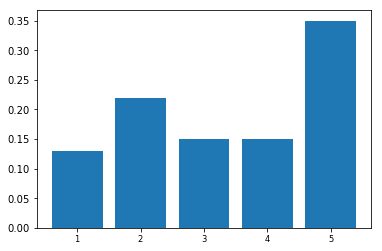

In [202]:
random_result = gen_score(best_playlist)
def energy1(result):
    return 10000*(1.0-(np.array([0,0,0,0.25,0.75])*result).sum())
print("Resulting loss: ", energy1(random_result))
print("Random sampling (1000 samples without replacement, optimized on weighted average between class 4 and 5) class probabilties: ",random_result)
plt.bar(range(len(random_result)), random_result)
plt.xticks(range(len(random_result)), [1,2,3,4,5], size='small')
locs, labels = plt.xticks()
plt.show()

## 3. Simulated annealing

In [98]:
#Adapted from simanneal package
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals
import copy
import math
import sys
import time
import random
import signal
import pickle
import datetime
import abc


def round_figures(x, n):
    """Returns x rounded to n significant figures."""
    return round(x, int(n - math.ceil(math.log10(abs(x)))))


def time_string(seconds):
    """Returns time in seconds as a string formatted HHHH:MM:SS."""
    s = int(round(seconds))  # round to nearest second
    h, s = divmod(s, 3600)   # get hours and remainder
    m, s = divmod(s, 60)     # split remainder into minutes and seconds
    return '%4i:%02i:%02i' % (h, m, s)


class Annealer(object):

    """Performs simulated annealing by calling functions to calculate
    energy and make moves on a state.  The temperature schedule for
    annealing may be provided manually or estimated automatically.
    """

    __metaclass__ = abc.ABCMeta
    Tmax = 25000.0
    Tmin = 2.5
    steps = 50000
    updates = 100
    copy_strategy = 'deepcopy'
    user_exit = False
    save_state_on_exit = True
    best_state = None

    def __init__(self, initial_state=None, load_state=None):
        if initial_state:
            self.state = self.copy_state(initial_state)
        elif load_state:
            with open(load_state, 'rb') as fh:
                self.state = pickle.load(fh)
        else:
            raise ValueError('No valid values supplied for neither \
            initial_state nor load_state')

        signal.signal(signal.SIGINT, self.set_user_exit)

    def save_state(self, fname=None):
        """Saves state"""
        if not fname:
            date = datetime.datetime.now().strftime("%Y-%m-%dT%Hh%Mm%Ss")
            fname = date + "_energy_" + str(self.energy()) + ".state"
        with open(fname, "wb") as fh:
            pickle.dump(self.state, fh)

    @abc.abstractmethod
    def move(self):
        """Create a state change"""
        pass

    @abc.abstractmethod
    def energy(self):
        """Calculate state's energy"""
        pass

    def set_user_exit(self, signum, frame):
        """Raises the user_exit flag, further iterations are stopped
        """
        self.user_exit = True

    def set_schedule(self, schedule):
        """Takes the output from `auto` and sets the attributes
        """
        self.Tmax = schedule['tmax']
        self.Tmin = schedule['tmin']
        self.steps = int(schedule['steps'])
        self.updates = int(schedule['updates'])

    def copy_state(self, state):
        """Returns an exact copy of the provided state
        Implemented according to self.copy_strategy, one of
        * deepcopy : use copy.deepcopy (slow but reliable)
        * slice: use list slices (faster but only works if state is list-like)
        * method: use the state's copy() method
        """
        if self.copy_strategy == 'deepcopy':
            return copy.deepcopy(state)
        elif self.copy_strategy == 'slice':
            return state[:]
        elif self.copy_strategy == 'method':
            return state.copy()

    def update(self, *args, **kwargs):
        """Wrapper for internal update.
        If you override the self.update method,
        you can chose to call the self.default_update method
        from your own Annealer.
        """
        self.default_update(*args, **kwargs)

    def default_update(self, step, T, E, acceptance, improvement):
        """Default update, outputs to stderr.
        Prints the current temperature, energy, acceptance rate,
        improvement rate, elapsed time, and remaining time.
        The acceptance rate indicates the percentage of moves since the last
        update that were accepted by the Metropolis algorithm.  It includes
        moves that decreased the energy, moves that left the energy
        unchanged, and moves that increased the energy yet were reached by
        thermal excitation.
        The improvement rate indicates the percentage of moves since the
        last update that strictly decreased the energy.  At high
        temperatures it will include both moves that improved the overall
        state and moves that simply undid previously accepted moves that
        increased the energy by thermal excititation.  At low temperatures
        it will tend toward zero as the moves that can decrease the energy
        are exhausted and moves that would increase the energy are no longer
        thermally accessible."""

        elapsed = time.time() - self.start
        if step == 0:
            print(' Temperature        Energy    Accept   Improve     Elapsed   Remaining',
                  file=sys.stderr)
            print('\r%12.5f  %12.2f                      %s            ' %
                  (T, E, time_string(elapsed)), file=sys.stderr, end="\r"),
            sys.stderr.flush()
        else:
            remain = (self.steps - step) * (elapsed / step)
            print('\r%12.5f  %12.2f  %7.2f%%  %7.2f%%  %s  %s\r' %
                  (T, E, 100.0 * acceptance, 100.0 * improvement,
                   time_string(elapsed), time_string(remain)), file=sys.stderr, end="\r"),
            sys.stderr.flush()

    def anneal(self):
        """Minimizes the energy of a system by simulated annealing.
        Parameters
        state : an initial arrangement of the system
        Returns
        (state, energy): the best state and energy found.
        """
        step = 0
        self.start = time.time()

        # Precompute factor for exponential cooling from Tmax to Tmin
        if self.Tmin <= 0.0:
            raise Exception('Exponential cooling requires a minimum "\
                "temperature greater than zero.')
        Tfactor = -math.log(self.Tmax / self.Tmin)

        # Note initial state
        T = self.Tmax
        E = self.energy()
        prevState = self.copy_state(self.state)
        prevEnergy = E
        self.best_state = self.copy_state(self.state)
        self.best_energy = E
        trials, accepts, improves = 0, 0, 0
        if self.updates > 0:
            updateWavelength = self.steps / self.updates
            self.update(step, T, E, None, None)

        # Attempt moves to new states
        while step < self.steps and not self.user_exit:
            step += 1
            T = self.Tmax * math.exp(Tfactor * step / self.steps)
            #print(T)
            self.allt.append(T)
            self.allE.append(E)
            self.move()
            E = self.energy()
            dE = E - prevEnergy
            trials += 1
            if dE > 0.0 and math.exp(-dE / T) < random.random():
                # Restore previous state
                self.state = self.copy_state(prevState)
                E = prevEnergy
            else:
                # Accept new state and compare to best state
                accepts += 1
                if dE < 0.0:
                    improves += 1
                prevState = self.copy_state(self.state)
                prevEnergy = E
                if E < self.best_energy:
                    self.best_state = self.copy_state(self.state)
                    self.best_energy = E
            if self.updates > 1:
                if (step // updateWavelength) > ((step - 1) // updateWavelength):
                    self.update(
                        step, T, E, accepts / trials, improves / trials)
                    trials, accepts, improves = 0, 0, 0

        # line break after progress output
        print('')

        self.state = self.copy_state(self.best_state)
        if self.save_state_on_exit:
            self.save_state()
        # Return best state and energy
        return self.best_state, self.best_energy

    def auto(self, minutes, steps=2000):
        """Minimizes the energy of a system by simulated annealing with
        automatic selection of the temperature schedule.
        Keyword arguments:
        state -- an initial arrangement of the system
        minutes -- time to spend annealing (after exploring temperatures)
        steps -- number of steps to spend on each stage of exploration
        Returns the best state and energy found."""

        def run(T, steps):
            """Anneals a system at constant temperature and returns the state,
            energy, rate of acceptance, and rate of improvement."""
            E = self.energy()
            prevState = self.copy_state(self.state)
            prevEnergy = E
            accepts, improves = 0, 0
            for step in range(steps):
                self.move()
                E = self.energy()
                dE = E - prevEnergy
                if dE > 0.0 and math.exp(-dE / T) < random.random():
                    self.state = self.copy_state(prevState)
                    E = prevEnergy
                else:
                    accepts += 1
                    if dE < 0.0:
                        improves += 1
                    prevState = self.copy_state(self.state)
                    prevEnergy = E
            return E, float(accepts) / steps, float(improves) / steps

        step = 0
        self.start = time.time()

        # Attempting automatic simulated anneal...
        # Find an initial guess for temperature
        T = 0.0
        E = self.energy()
        self.update(step, T, E, None, None)
        while T == 0.0:
            step += 1
            self.move()
            T = abs(self.energy() - E)

        # Search for Tmax - a temperature that gives 98% acceptance
        E, acceptance, improvement = run(T, steps)

        step += steps
        while acceptance > 0.98:
            T = round_figures(T / 1.5, 2)
            E, acceptance, improvement = run(T, steps)
            step += steps
            self.update(step, T, E, acceptance, improvement)
        while acceptance < 0.98:
            T = round_figures(T * 1.5, 2)
            E, acceptance, improvement = run(T, steps)
            step += steps
            self.update(step, T, E, acceptance, improvement)
        Tmax = T

        # Search for Tmin - a temperature that gives 0% improvement
        while improvement > 0.0:
            T = round_figures(T / 1.5, 2)
            E, acceptance, improvement = run(T, steps)
            step += steps
            self.update(step, T, E, acceptance, improvement)
        Tmin = T

        # Calculate anneal duration
        elapsed = time.time() - self.start
        duration = round_figures(int(60.0 * minutes * step / elapsed), 2)

        print('')  # New line after auto() output
        # Don't perform anneal, just return params
        return {'tmax': Tmax, 'tmin': Tmin, 'steps': duration}
    
#Contact GitHub API Training Shop Blog About
#© 2017 GitHub, Inc. Terms Privacy Security Status Help

In [99]:
#import simanneal
from __future__ import print_function
import math
import random
#from simanneal import Annealer

In [125]:
class TravellingSalesmanProblem(Annealer):

    """Test annealer with a travelling salesman problem.
    """
    
    # pass extra data (the distance matrix) into the constructor
    def __init__(self, candidate_songs, init_playlist=None):
        #self.state = np.array(['2LBkiUn4HmZQN1iV4Q09cn', '3Y10xQQJVB1yjwFQ0ItrY6'])
        if init_playlist !=None:
            state = init_playlist
        else:
            state = np.random.choice(candidate_songs,size=10,replace=False)
        self.starting = state
        self.candidate_songs = np.setdiff1d(candidate_songs,state)
        self.allt = []
        self.allE = []
        state=list(state)
        #self.features = features
        super(TravellingSalesmanProblem, self).__init__(state)  # important! 

    def move(self):
        """Swaps two cities in the route."""
        a = random.randint(0, len(self.state) - 1)
        b = random.randint(0, len(self.candidate_songs) - 1)
        #b = random.randint(0, len(self.state) - 1)
        #self.state[a], self.state[b] = self.state[b], self.state[a]
        #print(self.state[a],self.candidate_songs[b])
        reject = self.state[a]
        self.state[a] = self.candidate_songs[b]
        self.candidate_songs[b] = reject
        #print(self.state[a],self.candidate_songs[b])
        
    def energy(self): ## calculates the predicted number of followers
        """Calculates the predicted number of followers."""
        #print(self.state)
        result = gen_score(self.state)
        #print("Calculating energy: ", result)
        #return 1000*(1-(0.67*result[4] + 0.33*result[3]))
        return 10000*(1.0-(np.array([0,0,0,0.25,0.75])*result).sum())

### Tune the energy function for simulated annealing. 
#### We want ~40-60% initial chance of acceptance for a significant decrease in energy

In [126]:
def energy1(result):
    return 10000*(1.0-(np.array([0,0,0,0.25,0.75])*result).sum())

prevEnergy=energy1([ 0.23,  0.25,  0.19,  0.23,  0.1])
E = energy1([ 0.23,  0.25,  0.19,  0.23,  0.04])
# We want this kind of decrease in energy to be associated with something like 70% chance acceptance at first
dE = E - prevEnergy
T = 680
math.exp(-dE / T)

0.51594004821404

### Tune Simulated annealing

In [102]:
def tuneSimAnneal(candidates):
    tsp = TravellingSalesmanProblem(candidates)
    tsp.copy_strategy = "slice"  
    auto_schedule = tsp.auto(minutes=0.5, steps=10)
    auto_schedule['updates'] = auto_schedule['steps']/10
    return auto_schedule

In [103]:
schedules = []
for index, bucket in  enumerate([bucket1,bucket2,bucket3]):
    schedules.append(tuneSimAnneal(bucket))
    print("Bucket #", index+1," parameters: ", schedules[index])

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    30.00000       6750.00     0.00%     0.00%     0:00:17     1:31:11 Temperature        Energy    Accept   Improve     Elapsed   Remaining



Bucket # 1  parameters:  {u'steps': 270.0, u'tmax': 1700.0, u'tmin': 30.0, u'updates': 27.0}


    67.00000       8625.00    10.00%     0.00%     0:00:13     1:51:09 Temperature        Energy    Accept   Improve     Elapsed   Remaining



Bucket # 2  parameters:  {u'steps': 220.0, u'tmax': 530.0, u'tmin': 67.0, u'updates': 22.0}


     7.30000       6400.00    10.00%     0.00%     0:00:27     1:53:25


Bucket # 3  parameters:  {u'steps': 220.0, u'tmax': 1500.0, u'tmin': 7.3, u'updates': 22.0}


### Run Simulated Annealing

In [123]:
def runSimulatedAnnealing(candidates, schedule, init_playlist=None):
    
    # Run sim anneal
    tsp = TravellingSalesmanProblem(candidates, init_playlist)
    tsp.set_schedule(schedule)
    state, e = tsp.anneal()
    resulting_playlist_sim_anneal = state
    start = gen_score(tsp.starting)
    print(schedule)

    # Visualize annealing
    plt.plot(range(int(schedule['steps'])), tsp.allE)
    plt.show()
    plt.plot(range(int(schedule['steps'])), tsp.allt)
    plt.show()
#     print(tsp.allE, tsp.allt)
#     plt.bar(range(len(tsp.st)), start)
#     plt.xticks(range(len(start)), [1,2,3,4,5], size='small')
#     locs, labels = plt.xticks()
#     plt.show()
#     end = gen_score(resulting_playlist_sim_anneal)

    # Visualize starting point
    print("Starting class probabilties: ",start)
    print(energy1(start))
    plt.bar(range(len(start)), start)
    plt.xticks(range(len(start)), [1,2,3,4,5], size='small')
    locs, labels = plt.xticks()
    plt.show()
    end = gen_score(resulting_playlist_sim_anneal)

    # Visualize ending point
    print("Ending class probabilties: ",end )
    print(energy1(end))
    plt.bar(range(len(end)), end)
    plt.xticks(range(len(end)), [1,2,3,4,5], size='small')
    locs, labels = plt.xticks()
    plt.show()

    return resulting_playlist_sim_anneal


### Bucket 1 results: Top tracks from related artists

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    30.00000       5125.00    10.00%     0.00%     0:00:32     0:00:00


{u'steps': 270.0, u'tmax': 1700.0, u'tmin': 30.0, u'updates': 27.0}


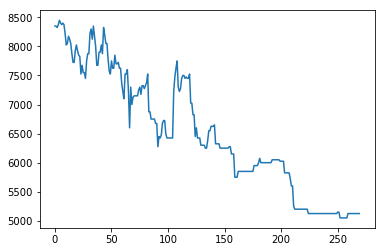

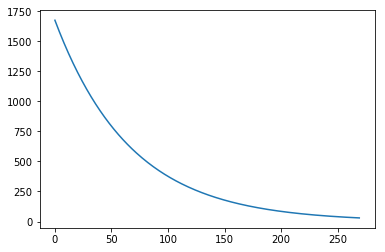

Starting class probabilties:  [ 0.18  0.24  0.24  0.18  0.16]
8350.0


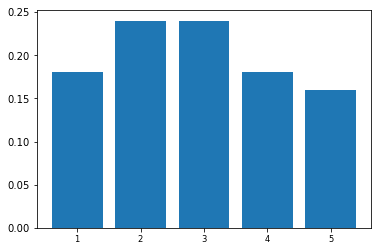

Ending class probabilties:  [ 0.08  0.11  0.07  0.12  0.62]
5050.0


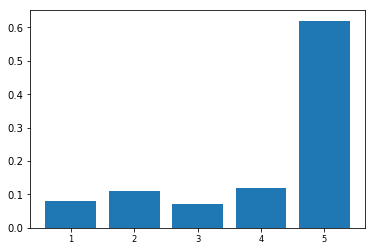

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    30.00000       5350.00    10.00%     0.00%     0:00:32     0:00:00


{u'steps': 270.0, u'tmax': 1700.0, u'tmin': 30.0, u'updates': 27.0}


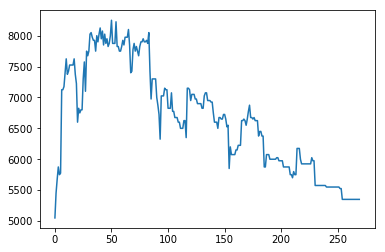

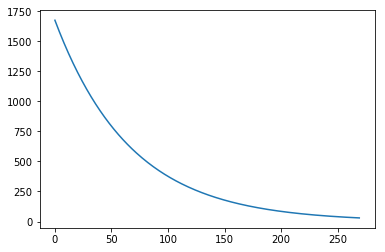

Starting class probabilties:  [ 0.08  0.11  0.07  0.12  0.62]
5050.0


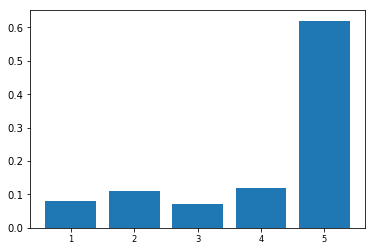

Ending class probabilties:  [ 0.08  0.11  0.07  0.12  0.62]
5050.0


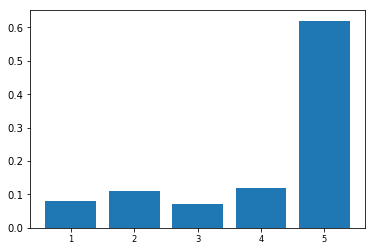

In [129]:
#if __name__ == '__main__':
bucket1_result = runSimulatedAnnealing(bucket1, schedules[0])
#bucket1_result_2 = runSimulatedAnnealing(bucket1, schedules[0], init_playlist=np.array(bucket1_result))

### Bucket 2 results: Any tracks from related artists

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     4.50000       6800.00     0.00%     0.00%     0:01:38     0:00:00


{u'steps': 990.0, u'tmax': 1300.0, u'tmin': 4.5, 'updates': 99.0}
Starting class probabilties:  [ 0.5   0.2   0.11  0.18  0.01]
9475.0


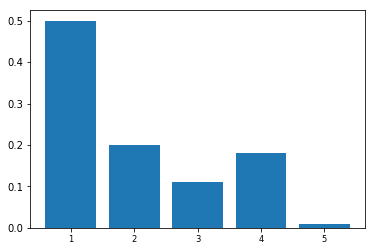

Ending class probabilties:  [ 0.16  0.23  0.11  0.11  0.39]
6800.0


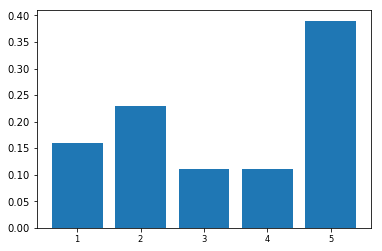

[u'03z8S3yZD1io0qenJSRZ0L',
 u'1jCNZGXATpwbQPmK4090x8',
 u'0PDUDa38GO8lMxLCRc4lL1',
 u'6MLsEJgVs8sF7EHee5QqaM',
 u'7wQVIel0NfQK9IMO7tDEN8',
 u'638fKB27P7UAmu3Aq0vEJ3',
 u'7FQgwxkgClQLTwEilUlscr',
 u'3ZIBLJhc82PoKXF9GVYQYE',
 u'78O8CIzX5ZMuJh39fQOR3i',
 u'5WX8mqlPovtMHXCsHGioPn']

In [305]:
runSimulatedAnnealing(bucket2, auto_schedule, num_runs=1)

### Bucket 3 results: Similar tracks from related artists (manhattan distance + spotify API features)

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    15.00000       6050.00     0.00%     0.00%     0:01:41     0:00:00


{u'steps': 900.0, u'tmax': 2000.0, u'tmin': 15.0, 'updates': 90.0}
Starting class probabilties:  [ 0.48  0.22  0.2   0.1   0.  ]
9750.0


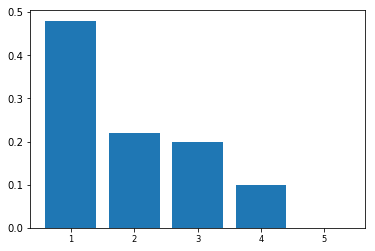

Ending class probabilties:  [ 0.11  0.11  0.18  0.11  0.49]
6050.0


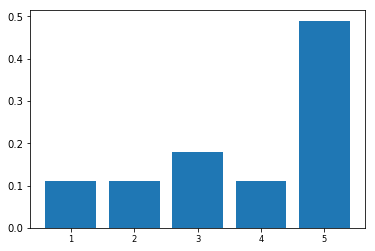

[u'7qiZfU4dY1lWllzX7mPBI3',
 u'7MxhtoiYMmro4VyBzUFm0P',
 u'2miLqfCa1ubJPAa7QtcfYL',
 u'7MxhtoiYMmro4VyBzUFm0P',
 u'7qiZfU4dY1lWllzX7mPBI3',
 u'7MxhtoiYMmro4VyBzUFm0P',
 u'7MxhtoiYMmro4VyBzUFm0P',
 u'7qiZfU4dY1lWllzX7mPBI3',
 u'7MxhtoiYMmro4VyBzUFm0P',
 u'1JOXtsCnIVcDkVi9SxMIso']

In [306]:
runSimulatedAnnealing(bucket3, schedules[2], num_runs=1)

In [216]:
# This got good results for all buckets
auto_schedule

{u'steps': 990.0, u'tmax': 1300.0, u'tmin': 4.5, 'updates': 99.0}

### Alternatively, mix buckets together (e.g. take 60% similar songs, 40% top tracks)

## loss function over time, decay of temperature

In [307]:
def mixBuckets(bucket_one, bucket_two, bucket_two_ratio):
    n_sample_bucket_two = len(bucket_one)*bucket_two_ratio/(1-bucket_two_ratio)
    sample_bucket_two = np.random.choice(bucket_two, replace=False,size= n_sample_bucket_two)
    mixed_bucket = np.concatenate((bucket_one, bucket_two))
    return np.unique(mixed_bucket)

In [308]:
mixed_bucket = mixBuckets(bucket1,bucket3,0.6)

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [309]:
schedule_mixed = tuneSimAnneal(mixed_bucket)

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    26.00000       6300.00     0.00%     0.00%     0:01:33     1:21:41

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    26.00000       6250.00     0.00%     0.00%     0:01:28     0:00:00


{u'steps': 900.0, u'tmax': 12000.0, u'tmin': 26.0, 'updates': 90.0}
Starting class probabilties:  [ 0.28  0.3   0.2   0.18  0.04]
9250.0


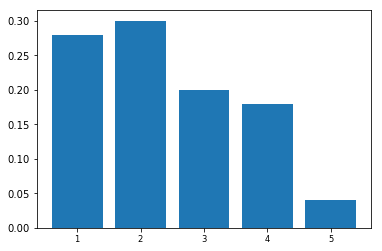

Ending class probabilties:  [ 0.17  0.12  0.15  0.09  0.47]
6250.0


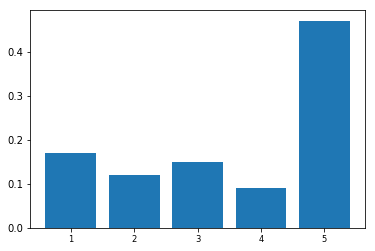

In [310]:
resulting_mixed = runSimulatedAnnealing(mixed_bucket, schedule_mixed)

In [ ]:
#sp.user_playlist_create("lware09", "capstone_demo", public=True)

In [282]:
import sys
import spotipy.util as util
util.prompt_for_user_token("lware09",scope="playlist-modify-private")


            You need to set your Spotify API credentials. You can do this by
            setting environment variables like so:

            export SPOTIPY_CLIENT_ID='your-spotify-client-id'
            export SPOTIPY_CLIENT_SECRET='your-spotify-client-secret'
            export SPOTIPY_REDIRECT_URI='your-app-redirect-url'

            Get your credentials at     
                https://developer.spotify.com/my-applications
        


SpotifyException: http status: 550, code:-1 - no credentials set

In [281]:


scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print "Usage: %s username" % (sys.argv[0],)
    sys.exit()

token = util.prompt_for_user_token(username, scope)

if token:
    sp = spotipy.Spotify(auth=token)
    results = sp.current_user_saved_tracks()
    for item in results['items']:
        track = item['track']
        print track['name'] + ' - ' + track['artists'][0]['name']
else:
    print "Can't get token for", username

AttributeError: 'Spotify' object has no attribute 'util'

### Resulting playlist!

In [259]:
from IPython.core.display import display, HTML

for each in resulting_mixed:
    song_id = related_all_features_with_seed[related_all_features_with_seed['id']==each]['id'].values[0]
    link='<a href=' + related_all_features_with_seed[related_all_features_with_seed['id']==each]['preview_url'].values[0] + '>preview related song</a>'
    print(related_all_features_with_seed[related_all_features_with_seed['id']==each]['artists'].values[0])
    link = "<iframe src=\"https://open.spotify.com/embed?uri=spotify:track:" + song_id + "\"frameborder=\"0\" allowtransparency=\"true\"></iframe>"
    #print(link)
    display(HTML(link))


Ellie Goulding


One Direction


Olly Murs


Olly Murs


James Blunt


James Bay


ZAYN


Birdy


Clean Bandit


Sam Smith


### Appendix: Travelling Salesman Example for Simulated Annealing 

In [279]:
from __future__ import print_function
import math
import random
from simanneal import Annealer


def distance(a, b):
    """Calculates distance between two latitude-longitude coordinates."""
    R = 3963  # radius of Earth (miles)
    lat1, lon1 = math.radians(a[0]), math.radians(a[1])
    lat2, lon2 = math.radians(b[0]), math.radians(b[1])
    return math.acos(math.sin(lat1) * math.sin(lat2) +
                     math.cos(lat1) * math.cos(lat2) * math.cos(lon1 - lon2)) * R


class TravellingSalesmanProblem(Annealer):

    """Test annealer with a travelling salesman problem.
    """
    
    # pass extra data (the distance matrix) into the constructor
    def __init__(self, state, distance_matrix):
        self.distance_matrix = distance_matrix
        super(TravellingSalesmanProblem, self).__init__(state)  # important! 

    def move(self):
        """Swaps two cities in the route."""
        a = random.randint(0, len(self.state) - 1)
        b = random.randint(0, len(self.state) - 1)
        self.state[a], self.state[b] = self.state[b], self.state[a]

    def energy(self):
        """Calculates the length of the route."""
        e = 0
        for i in range(len(self.state)):
            e += self.distance_matrix[self.state[i-1]][self.state[i]]
        return e



if __name__ == '__main__':

    # latitude and longitude for the twenty largest U.S. cities
    cities = {
        'New York City': (40.72, 74.00),
        'Los Angeles': (34.05, 118.25),
        'Chicago': (41.88, 87.63),
        'Houston': (29.77, 95.38),
        'Phoenix': (33.45, 112.07),
        'Philadelphia': (39.95, 75.17),
        'San Antonio': (29.53, 98.47),
        'Dallas': (32.78, 96.80),
        'San Diego': (32.78, 117.15),
        'San Jose': (37.30, 121.87),
        'Detroit': (42.33, 83.05),
        'San Francisco': (37.78, 122.42),
        'Jacksonville': (30.32, 81.70),
        'Indianapolis': (39.78, 86.15),
        'Austin': (30.27, 97.77),
        'Columbus': (39.98, 82.98),
        'Fort Worth': (32.75, 97.33),
        'Charlotte': (35.23, 80.85),
        'Memphis': (35.12, 89.97),
        'Baltimore': (39.28, 76.62)
    }

    # initial state, a randomly-ordered itinerary
    init_state = list(cities.keys())
    random.shuffle(init_state)

    # create a distance matrix
    distance_matrix = {}
    for ka, va in cities.items():
        distance_matrix[ka] = {}
        for kb, vb in cities.items():
            if kb == ka:
                distance_matrix[ka][kb] = 0.0
            else:
                distance_matrix[ka][kb] = distance(va, vb)

    tsp = TravellingSalesmanProblem(init_state, distance_matrix)
    # since our state is just a list, slice is the fastest way to copy
    tsp.copy_strategy = "slice"  
    state, e = tsp.anneal()

    while state[0] != 'New York City':
        state = state[1:] + state[:1]  # rotate NYC to start
    print("%i mile route:" % e)
    for city in state:
        print("\t", city)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000       6883.00     5.20%     0.00%     0:00:01     0:00:00


6845 mile route:
	 New York City
	 Philadelphia
	 Baltimore
	 Charlotte
	 Jacksonville
	 Houston
	 Austin
	 San Antonio
	 Phoenix
	 San Diego
	 Los Angeles
	 San Jose
	 San Francisco
	 Fort Worth
	 Dallas
	 Memphis
	 Indianapolis
	 Chicago
	 Detroit
	 Columbus
